In [1]:
import glob
import os
import librosa
import numpy as np

import h5py

def bringdata(filename):
    hdf5Path = filename
    dataset = h5py.File(hdf5Path, 'r')
    data = dataset['audio']
    labels = dataset['labels']
    print 'data brought', filename
    print data.shape, labels.shape
    return data, labels

traindata, trainlabel = bringdata('train')
testdata, testlabel = bringdata('test')

data brought train
(48840, 60, 41, 2) (48840, 10)
data brought test
(5218, 60, 41, 2) (5218, 10)


In [2]:
import matplotlib.pyplot as plt

# matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [3]:
import tensorflow as tf

frames = 41
bands = 60
num_channels = 2

#feature_size = 2460 #60x41
num_labels = 10

X = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

keep_prob1 = tf.placeholder(tf.float32)  # use for dropout
keep_prob2 = tf.placeholder(tf.float32)

# conv1
with tf.variable_scope('conv1') as scope:
    weights = tf.get_variable('weights', shape=[5, 5, 2, 256], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(seed=0))

    biases = tf.get_variable('biases', shape=[256], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.1))

    conv1 = tf.nn.relu(tf.nn.conv2d(X, weights, strides=[1, 1, 1, 1], padding='SAME') + biases)

# pool1
with tf.variable_scope('pool1') as scope:
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='VALID', name='pool1')
# conv2
with tf.variable_scope('conv2') as scope:
    weights = tf.get_variable('weights', shape=[3, 3, 256, 384], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(seed=0))

    biases = tf.get_variable('biases', shape=[384], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.1))

    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, weights, strides=[1, 1, 1, 1], padding='SAME') + biases)
    conv2 = tf.nn.local_response_normalization(conv2, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)

# conv3
with tf.variable_scope('conv3') as scope:
    weights = tf.get_variable('weights', shape=[3, 3, 384, 384], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(seed=0))

    biases = tf.get_variable('biases', shape=[384], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.1))

    conv3 = tf.nn.relu(tf.nn.conv2d(conv2, weights, strides=[1, 1, 1, 1], padding='SAME') + biases)

# conv4
with tf.variable_scope('conv4') as scope:
    weights = tf.get_variable('weights', shape=[3, 3, 384, 256], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(seed=0))

    biases = tf.get_variable('biases', shape=[256], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.1))

    conv4 = tf.nn.relu(tf.nn.conv2d(conv3, weights, strides=[1, 1, 1, 1], padding='SAME') + biases)

# pool2
with tf.variable_scope('pool2') as scope:
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='VALID', name='pool5')
pool2_flatten = tf.contrib.layers.flatten(pool2)  # flatten pool3 to shape of (128,16*16*32)

# fully connected layer 1 and dropout
fc1 = tf.contrib.layers.fully_connected(pool2_flatten, 256, activation_fn=tf.nn.relu)

# fc1_drop = tf.nn.dropout(fc1, keep_prob1)

# fully connected layer 2 and dropout
fc2 = tf.contrib.layers.fully_connected(fc1, 256, activation_fn=tf.nn.relu)

fc2_drop = tf.nn.dropout(fc2, keep_prob2)

# fully connected layer 3
fc3 = tf.contrib.layers.fully_connected(fc2_drop, num_labels, activation_fn=None)


In [4]:
# loss function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = fc3, labels = Y))
train_optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
cost_history = np.empty(shape=[1], dtype=float)

# accuracy
correct_prediction = tf.equal(tf.argmax(fc3,1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 / 100 done cost: 1.597317110488675
1 / 100 done cost: 1.2347905382687705
2 / 100 done cost: 1.0092768859451022
3 / 100 done cost: 0.8564360168685733
4 / 100 done cost: 0.7420460582557998
5 / 100 done cost: 0.6505663876678278
6 / 100 done cost: 0.5757687758198511
7 / 100 done cost: 0.5272158701579275
8 / 100 done cost: 0.4933683366152996
9 / 100 done cost: 0.4245617244835294
10 / 100 done cost: 0.3646092247549454
11 / 100 done cost: 0.33455748209122516
12 / 100 done cost: 0.3227030589917112
13 / 100 done cost: 0.2810479159270921
14 / 100 done cost: 0.23881519315703897
15 / 100 done cost: 0.20978090447116712
16 / 100 done cost: 0.20568745688058337
17 / 100 done cost: 0.17795000664858876
18 / 100 done cost: 0.19440308775394308
19 / 100 done cost: 0.1555656609347924
20 / 100 done cost: 0.13765910433001066
21 / 100 done cost: 0.11382994652631363
22 / 100 done cost: 0.1247320983431453
23 / 100 done cost: 0.0999379853

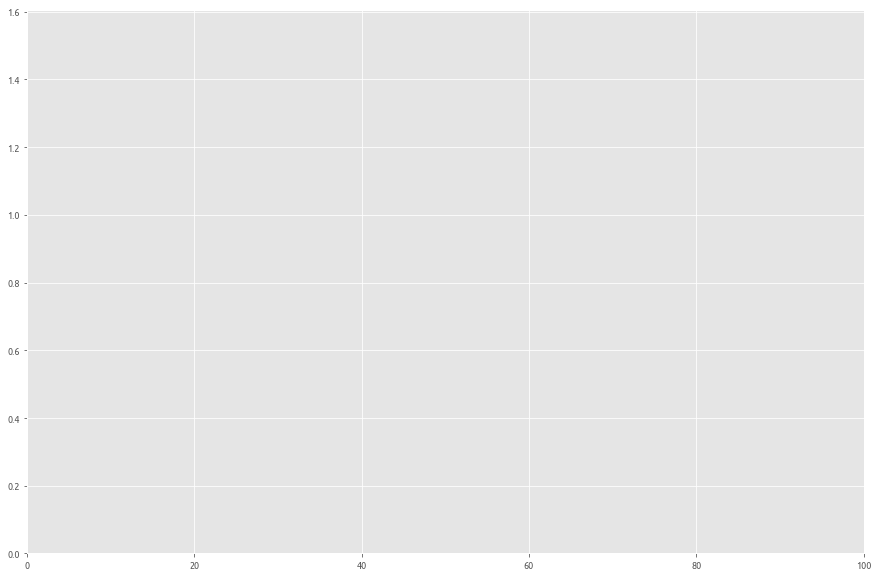

TypeError: 'numpy.float32' object does not support item assignment

In [11]:
batch_size = 8
iterations = 100

recall_path = "model/"

with tf.Session() as session:
    tf.initialize_all_variables().run()

    # Restore the network
    if tf.train.get_checkpoint_state(recall_path): 
        saver = tf.train.Saver()
        saver.restore(session, recall_path)
        print("good!")
    
    # Training
    for itr in range(iterations):

        c_sum = 0
        
        for i in range(48840/batch_size):
            offset = (i * batch_size) % (trainlabel.shape[0] - batch_size)
            batch_x = traindata[offset:(offset + batch_size), :, :, :]
            batch_y = trainlabel[offset:(offset + batch_size), :]

            _, c = session.run([train_optimizer, cost], feed_dict={X: batch_x, Y: batch_y, keep_prob1: 0.5, keep_prob2: 1.0})
            c_sum += c / (48840/batch_size)

        cost_history = np.append(cost_history, c_sum)

        print itr, '/', iterations, 'done', 'cost:', c_sum

        if itr % 5 == 0:
            saver = tf.train.Saver()
            saver.save(session, recall_path, write_meta_graph=False)
        
    fig = plt.figure(figsize=(15, 10))
    plt.plot(cost_history=True)
    plt.axis([0, iterations, 0, np.max(cost_history)])
    plt.show()

    # Test
    acc_total = []
    for i in range(3):
        offset = (i * batch_size) % (trainlabel.shape[0] - batch_size)
        testbatch_x = testdata[offset:(offset + batch_size), :, :, :]
        testbatch_y = testlabel[offset:(offset + batch_size), :]
        acc[i] = session.run(accuracy, feed_dict={X: testbatch_x, Y: testbatch_y, keep_prob1: 1.0, keep_prob2: 1.0})

    print acc_total
    
    